# Определение стоимости автомобилей

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В вашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Вам нужно построить модель для определения стоимости. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

## Подготовка данных

In [125]:
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

#from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OrdinalEncoder

from sklearn.model_selection import RandomizedSearchCV

from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor

import warnings
warnings.simplefilter('ignore')

import time

In [126]:
try:
    data= pd.read_csv('C:\\Users\\user\\Yandex\\Praktika_10\\datasets\\autos.csv')
except:
    data = pd.read_csv('/datasets/autos.csv') 

In [127]:
data.shape

(354369, 16)

In [128]:
data.head()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


In [129]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
DateCrawled          354369 non-null object
Price                354369 non-null int64
VehicleType          316879 non-null object
RegistrationYear     354369 non-null int64
Gearbox              334536 non-null object
Power                354369 non-null int64
Model                334664 non-null object
Kilometer            354369 non-null int64
RegistrationMonth    354369 non-null int64
FuelType             321474 non-null object
Brand                354369 non-null object
NotRepaired          283215 non-null object
DateCreated          354369 non-null object
NumberOfPictures     354369 non-null int64
PostalCode           354369 non-null int64
LastSeen             354369 non-null object
dtypes: int64(7), object(9)
memory usage: 43.3+ MB


### Колонки DateCrawled, DateCreated , LastSeen

Переведем колонки DateCrawled, DateCreated , LastSeen в формат даты.

In [130]:
data['DateCrawled'] = pd.to_datetime(data['DateCrawled'], format='%Y-%m-%dT%H:%M:%S')
data['DateCreated'] = pd.to_datetime(data['DateCreated'], format='%Y-%m-%dT%H:%M:%S')
data['LastSeen'] = pd.to_datetime(data['LastSeen'], format='%Y-%m-%dT%H:%M:%S')

Посмотрим диапазон дат в этих колонках

In [131]:
data.DateCrawled.describe()

count                  354369
unique                 271174
top       2016-03-24 14:49:47
freq                        7
first     2016-03-05 14:06:22
last      2016-04-07 14:36:58
Name: DateCrawled, dtype: object

In [132]:
data.DateCreated.describe()

count                  354369
unique                    109
top       2016-04-03 00:00:00
freq                    13719
first     2014-03-10 00:00:00
last      2016-04-07 00:00:00
Name: DateCreated, dtype: object

In [133]:
data.LastSeen.describe()

count                  354369
unique                 179150
top       2016-04-06 13:45:54
freq                       17
first     2016-03-05 14:15:08
last      2016-04-07 14:58:51
Name: LastSeen, dtype: object

У анкеты есть три даты: дата выгрузки, создания, и последней активности пользователя. Для анализа нам нужно понимать на какую дату цену в объявлении можно считать рыночной. Дата создания анкеты нам не подойдет, потому что с тех пор цена в объявлении могла меняться. Дата выгрузки анкеты также не подойдет, потому что цена в объявлении уже может быть не рыночной, но клиент еще не успел зайти и поменять ее. Таким образом остается дата последнего посещения, когда клиент заходил , видел свое объявление и посчитал его актуальным.

Однако если смотреть диапазон дат в LastSeen то мы видим, что все пользователи заходили в свои анкеты в течение месяца (март-апрель 2016). Таким образом можем считать, что цены на авто у нас находятся в примерно одинаковый срез времени и колонкой LastSeen тоже можно принебречь.

Удалим колонки 'DateCrawled', 'DateCreated', 'LastSeen'

In [134]:
data.drop(['DateCrawled', 'DateCreated','LastSeen'], axis = 1, inplace = True)

### Пропуски

Есть пропуски в колонках VehicleType , FuelType , NotRepaired. 

Т.к. это все категориальные колонки, то можем заменить пропуски на значение "unknown"

In [135]:
data.fillna("unknown", inplace = True)

### Выбросы

Построим гистограмму призников

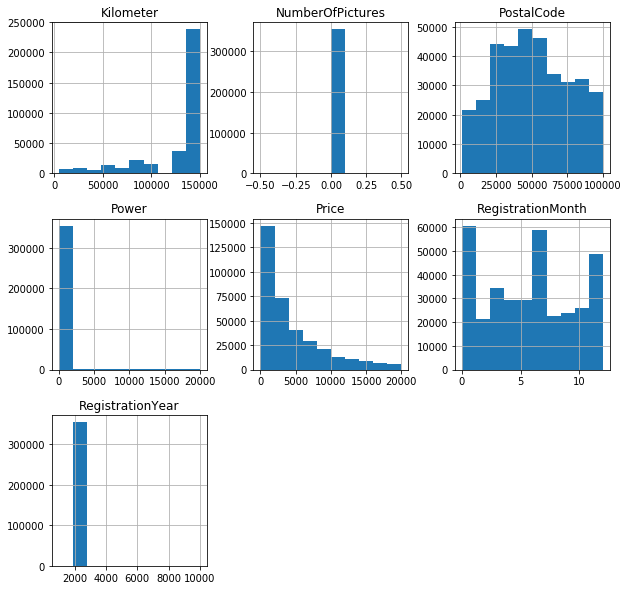

In [136]:
data.hist(figsize = (10,10));

In [137]:
data.describe()

,Price,RegistrationYear,Power,Kilometer,RegistrationMonth,NumberOfPictures,PostalCode
count,354369.000000,354369.000000,354369.000000,354369.000000,354369.000000,354369.0,354369.000000
mean,4416.656776,2004.234448,110.094337,128211.172535,5.714645,0.0,50508.689087
std,4514.158514,90.227958,189.850405,37905.341530,3.726421,0.0,25783.096248
min,0.000000,1000.000000,0.000000,5000.000000,0.000000,0.0,1067.000000
25%,1050.000000,1999.000000,69.000000,125000.000000,3.000000,0.0,30165.000000
50%,2700.000000,2003.000000,105.000000,150000.000000,6.000000,0.0,49413.000000
75%,6400.000000,2008.000000,143.000000,150000.000000,9.000000,0.0,71083.000000
max,20000.000000,9999.000000,20000.000000,150000.000000,12.000000,0.0,99998.000000


Есть записи где целевой признак Price = 0, посмотрим сколько их и удалим

In [138]:
data[data['Price'] == 0]['Price'].count()

10772

In [139]:
data = data.query('Price > 0')

В датах регистрации ТС есть выбросы с годом более 2016 (год выгрузки анкет) и меньше 1900г. Приравняем эти даты к 0.

In [140]:
data['RegistrationYear'].loc[(data['RegistrationYear'] > 2016) | (data['RegistrationYear'] < 1900)] = 0

Приравняем к нулю мощности более 2200 (цифру взял из https://www.a777aa77.ru/power.php)

In [141]:
data['Power'].loc[data['Power'] > 2200] = 0

### Колонки NumberOfPictures, RegistrationMonth, PostalCode

Колонка NumberOfPictures во всех записях равна 0, удалим ее

In [142]:
data.drop(['NumberOfPictures'], axis = 1, inplace = True)

Колонка RegistrationMonth является избыточной информацией для даты производства авто, т.к. все обычно ориентируются на год регистрации. Удалим ее.

In [143]:
data.drop(['RegistrationMonth'], axis = 1, inplace = True)

По значениям PostalCode гугл говорит, что все объявления возможно родом из Германии. Удалим PostalCode считая, что цена в разных районах Германии не сильно отличается.

In [144]:
data.drop(['PostalCode'], axis = 1, inplace = True)

## Обучение моделей

### Подготовка выборок

#### Категориальные признаки

In [145]:
cat_features = ['VehicleType','Gearbox','Model','FuelType','FuelType','Brand','NotRepaired']

In [146]:
for col in cat_features:
    data[col] = data[col].astype('category')

#### Выборки без преобразования категориальных признаков

Будут использованы в CatBoost и LightGBM

In [147]:
target = data['Price']
features = data.drop(['Price'] , axis=1)

In [148]:
features_train, features_valid_and_test, target_train, target_valid_and_test = train_test_split\
                        (features, target, test_size=0.4, random_state=12345)

features_test, features_valid, target_test, target_valid = train_test_split\
                        (features_valid_and_test, target_valid_and_test, test_size=0.5, random_state=12345)

#### Выборки с преобразованием категориальных признаков

Будут использованы в DecisionTreeRegressor и RandomForestRegressor

Воспользуемся OrdinalEncoder

In [150]:
target_le = data['Price']
features_le = data.drop(['Price'] , axis=1)

enc = OrdinalEncoder()
features_le[cat_features] = enc.fit_transform(features_le[cat_features])


features_train_le, features_valid_and_test_le, target_train_le, target_valid_and_test_le = train_test_split\
                        (features_le, target_le, test_size=0.4, random_state=12345)

features_test_le, features_valid_le, target_test_le, target_valid_le = train_test_split\
                        (features_valid_and_test_le, target_valid_and_test_le, test_size=0.5, random_state=12345)

#### Создание результирующего датафрейма

In [151]:
results = pd.DataFrame(columns = ['valid_score','test_score','fit_time','predict_time'])

### Обучение модели DecisionTreeRegressor

#### Поиск лучшего гиперпараметра

In [152]:
tree = DecisionTreeRegressor(random_state = 12345)
params = {
    'max_depth' : range(9,15,2)
}
tree_model = RandomizedSearchCV (tree,params, cv=3, random_state = 12345,verbose = 2)

In [153]:
%%time
tree_model.fit(features_train_le,target_train_le)

Fitting 3 folds for each of 3 candidates, totalling 9 fits
[CV] max_depth=9 .....................................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] ...................................... max_depth=9, total=   0.3s
[CV] max_depth=9 .....................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.3s remaining:    0.0s


[CV] ...................................... max_depth=9, total=   0.4s
[CV] max_depth=9 .....................................................
[CV] ...................................... max_depth=9, total=   0.4s
[CV] max_depth=11 ....................................................
[CV] ..................................... max_depth=11, total=   0.4s
[CV] max_depth=11 ....................................................
[CV] ..................................... max_depth=11, total=   0.4s
[CV] max_depth=11 ....................................................
[CV] ..................................... max_depth=11, total=   0.5s
[CV] max_depth=13 ....................................................
[CV] ..................................... max_depth=13, total=   0.4s
[CV] max_depth=13 ....................................................
[CV] ..................................... max_depth=13, total=   0.4s
[CV] max_depth=13 ....................................................
[CV] .

[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:    3.6s finished


CPU times: user 4.04 s, sys: 8.04 ms, total: 4.05 s
Wall time: 4.22 s


RandomizedSearchCV(cv=3, error_score='raise-deprecating',
                   estimator=DecisionTreeRegressor(criterion='mse',
                                                   max_depth=None,
                                                   max_features=None,
                                                   max_leaf_nodes=None,
                                                   min_impurity_decrease=0.0,
                                                   min_impurity_split=None,
                                                   min_samples_leaf=1,
                                                   min_samples_split=2,
                                                   min_weight_fraction_leaf=0.0,
                                                   presort=False,
                                                   random_state=12345,
                                                   splitter='best'),
                   iid='warn', n_iter=10, n_jobs=None,
                   param_d

In [154]:
tree_model.best_params_

{'max_depth': 13}

#### Обучение на лучшем гиперпараметре

In [155]:
tree = DecisionTreeRegressor(max_depth = 13, random_state = 12345)

In [156]:
start = time.time()
tree.fit(features_train_le,target_train_le)
end = time.time()
fit_time = end-start

In [157]:
start = time.time()
predictions = tree.predict(features_valid_le)
end = time.time()
predict_time = end-start

In [158]:
valid_score = mean_squared_error(target_valid_le, predictions)**0.5

In [159]:
test_score = mean_squared_error(target_test_le, tree.predict(features_test_le))**0.5

In [160]:
results.loc['tree'] = [valid_score,test_score,fit_time,predict_time]

### Обучение модели RandomForestRegressor

#### Поиск лучшего гиперпараметра

In [161]:
forest = RandomForestRegressor(random_state = 12345)
params = {
    'max_depth' : range(9,15,2),
    'n_estimators' : range (10,51,10)
}
forest_model = RandomizedSearchCV (forest,params, cv=2, random_state = 12345,verbose = 2)

In [162]:
%%time
forest_model.fit(features_train_le,target_train_le)

Fitting 2 folds for each of 10 candidates, totalling 20 fits
[CV] n_estimators=10, max_depth=9 ....................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] ..................... n_estimators=10, max_depth=9, total=   1.8s
[CV] n_estimators=10, max_depth=9 ....................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.8s remaining:    0.0s


[CV] ..................... n_estimators=10, max_depth=9, total=   1.7s
[CV] n_estimators=20, max_depth=13 ...................................
[CV] .................... n_estimators=20, max_depth=13, total=   4.4s
[CV] n_estimators=20, max_depth=13 ...................................
[CV] .................... n_estimators=20, max_depth=13, total=   4.7s
[CV] n_estimators=30, max_depth=11 ...................................
[CV] .................... n_estimators=30, max_depth=11, total=   5.6s
[CV] n_estimators=30, max_depth=11 ...................................
[CV] .................... n_estimators=30, max_depth=11, total=   5.5s
[CV] n_estimators=40, max_depth=11 ...................................
[CV] .................... n_estimators=40, max_depth=11, total=   7.4s
[CV] n_estimators=40, max_depth=11 ...................................
[CV] .................... n_estimators=40, max_depth=11, total=   7.4s
[CV] n_estimators=40, max_depth=9 ....................................
[CV] .

[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:  1.9min finished


CPU times: user 2min 15s, sys: 82 ms, total: 2min 15s
Wall time: 2min 16s


RandomizedSearchCV(cv=2, error_score='raise-deprecating',
                   estimator=RandomForestRegressor(bootstrap=True,
                                                   criterion='mse',
                                                   max_depth=None,
                                                   max_features='auto',
                                                   max_leaf_nodes=None,
                                                   min_impurity_decrease=0.0,
                                                   min_impurity_split=None,
                                                   min_samples_leaf=1,
                                                   min_samples_split=2,
                                                   min_weight_fraction_leaf=0.0,
                                                   n_estimators='warn',
                                                   n_jobs=None, oob_score=False,
                                                   random_state=1

In [163]:
forest_model.best_params_

{'n_estimators': 50, 'max_depth': 13}

#### Обучение на лучшем гиперпараметре

In [164]:
forest = RandomForestRegressor(n_estimators = 50, max_depth = 13, random_state = 12345)

In [165]:
start = time.time()
forest.fit(features_train_le,target_train_le)
end = time.time()
fit_time = end-start

In [166]:
start = time.time()
predictions = forest.predict(features_valid_le)
end = time.time()
predict_time = end-start

In [167]:
valid_score = mean_squared_error(target_valid_le, predictions)**0.5

In [168]:
test_score = mean_squared_error(target_test_le, forest.predict(features_test_le))**0.5

In [169]:
results.loc['forest'] = [valid_score,test_score,fit_time,predict_time]

### Обучение модели CatBoost

In [170]:
cat = CatBoostRegressor(depth = 6,iterations = 200, random_seed = 12345)

In [171]:
start = time.time()
cat.fit(features_train, target_train, cat_features=cat_features)
end = time.time()
fit_time = end-start

0:	learn: 4425.0224577	total: 937ms	remaining: 3m 6s
1:	learn: 4341.6036020	total: 1.74s	remaining: 2m 52s
2:	learn: 4262.0320144	total: 2.44s	remaining: 2m 39s
3:	learn: 4184.4205030	total: 3.13s	remaining: 2m 33s
4:	learn: 4110.7921836	total: 3.73s	remaining: 2m 25s
5:	learn: 4038.0247649	total: 4.53s	remaining: 2m 26s
6:	learn: 3967.9941848	total: 5.33s	remaining: 2m 26s
7:	learn: 3900.9239818	total: 6.12s	remaining: 2m 26s
8:	learn: 3835.9798805	total: 6.83s	remaining: 2m 24s
9:	learn: 3773.5732197	total: 7.63s	remaining: 2m 24s
10:	learn: 3715.6879860	total: 8.43s	remaining: 2m 24s
11:	learn: 3659.0201696	total: 9.22s	remaining: 2m 24s
12:	learn: 3603.4818357	total: 9.93s	remaining: 2m 22s
13:	learn: 3549.6118650	total: 10.6s	remaining: 2m 21s
14:	learn: 3497.9060002	total: 11.4s	remaining: 2m 20s
15:	learn: 3447.2831353	total: 12.2s	remaining: 2m 20s
16:	learn: 3397.7045894	total: 13s	remaining: 2m 20s
17:	learn: 3348.2996688	total: 13.6s	remaining: 2m 17s
18:	learn: 3302.1701957

In [172]:
start = time.time()
predictions = cat.predict(features_valid)
end = time.time()
predict_time = end-start

In [173]:
valid_score = mean_squared_error(target_valid, predictions)**0.5

In [174]:
test_score = mean_squared_error(target_test, cat.predict(features_test))**0.5

In [175]:
results.loc['catboost'] = [valid_score,test_score,fit_time,predict_time]

### Обучение модели lightgbm

In [176]:
lgbm = LGBMRegressor (max_depth = 6, n_estimators = 800, random_state = 12345)

In [177]:
start = time.time()
lgbm.fit(features_train, target_train, categorical_feature = cat_features)
end = time.time()
fit_time = end-start

In [178]:
start = time.time()
predictions = lgbm.predict(features_valid)
end = time.time()
predict_time = end-start

In [179]:
valid_score = mean_squared_error(target_valid, predictions)**0.5

In [180]:
test_score = mean_squared_error(target_test, lgbm.predict(features_test))**0.5

In [181]:
results.loc['lgbm'] = [valid_score,test_score,fit_time,predict_time]

## Анализ моделей

In [182]:
results

,valid_score,test_score,fit_time,predict_time
tree,1980.237940,1947.758669,0.637003,0.015649
forest,1781.557135,1762.287744,20.542026,0.608544
catboost,1910.325236,1883.158949,146.605955,0.258134
lgbm,1603.295529,1591.524481,44.879563,9.224775


### Вывод
Модель LGBM победила по показателю RMSE и соотношению RMSE к fit_time. Однако стоит заметить, что этой модели требуется значительное время для предсказания. Если у нас стоит задача уменьшить время на предсказание и есть возможность увеличить время на обучение, то под такие задачи больше бы подошла модель CatBoost. 

При работе на локальном компьютере CatBoost показывает намного лучше показатели :
 - valid_score 1694.465363 
 - test_score 1675.100321
 - fit_time 82.788634
 - predict_time 0.247361
